In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm
from decoders import naiveBayes
import itertools
import h5py

import config


In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'


# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [3]:
# Load the data base
outPath = rootPath+dataPath+'HerminaDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()


In [ ]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']

In [ ]:
# Number of Units without Whines
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 97):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



In [4]:
# Number of Units with Whines
unitNames = np.unique(dfDataBase['site']+'_'+ dfDataBase['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBase['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBase['stim'][dfDataBase['site']+'_'+ dfDataBase['unit'] == unit]))
    # Select only Units with 110 stimuli (for now) or 97  if NW
    if (nstimsUnit[unit] == 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)

191


In [5]:
# Read the results of Part 1 Runs that includes all neurons

# Read the PC and Confusion matrices data base
# Use the following data if NW
#inPath = rootPath+dataPath+'HerminaDataBase1UnitPCNW.pkl'

inPath = rootPath+dataPath+'HerminaDataBase1UnitPC.pkl'
fileIn = open(inPath,"rb")
unitNamesFull = pk.load(fileIn)
confMatTot = pk.load(fileIn)
pcc = pk.load(fileIn)
fileIn.close()

# These are the neurons that we will be keeping  Use 13 if NW 12 otherwise.
indGood = np.argwhere(pcc > 12).flatten()
nGood = indGood.shape[0]

In [6]:
# Read the csv data file that has the area information

electrodeH = pd.read_csv(rootPath+dataPath+'HerminaGoodUnitsInfoRegion.csv')

In [7]:
electrodeH

,Unnamed: 0,Unnamed: 0.1,unitName,birdName,depth,electrode,cluster,decodingpcc,selectivityH,selectivityZ,rMean,rMin,rMax,rStd,z,xpos,ypos,region
0,0,0,ZF4F_2t_190612_101201_goodPlayback-e11-c31.pkl,ZF5M,9.5,10,115,25.980101,0.047651,0.080397,22.554656,-35.0,81.0,16.203165,1.272586,2.0,1.0,L_NCM
1,1,1,ZF4F_2t_190612_101201_goodPlayback-e16-c66.pkl,ZF4F,2.0,17,55,17.988497,0.069760,0.099178,8.152294,-18.0,73.0,10.661459,0.920148,1.0,1.0,CMM
2,2,2,ZF4F_2t_190612_101201_goodPlayback-e17-c36.pkl,ZF5M,8.0,12,76,17.937830,0.070974,0.103737,2.468599,-4.0,14.0,3.208191,0.729407,2.0,4.0,L
3,3,3,ZF4F_2t_190612_101201_goodPlayback-e17-c38.pkl,ZF7F,7.0,13,0,17.927170,0.186117,0.678361,1.594718,-10.0,23.0,4.217952,0.414690,1.0,2.0,L
4,4,4,ZF4F_2t_190612_101201_goodPlayback-e19-c2.pkl,ZF4F,2.0,11,62,17.566820,0.024578,0.618425,3.368159,-46.0,42.0,11.679969,0.288012,2.0,3.0,CLM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,ZF7F_7t_190806_115742_goodPlayback-e17-c31.pkl,ZF6M,2.0,15,32,11.411733,0.068468,0.524894,0.569120,-8.0,11.0,2.299242,0.247303,1.0,0.0,CMM
96,96,96,ZF7F_7t_190806_115742_goodPlayback-e19-c32.pkl,ZF5M,11.0,20,66,11.253594,0.077864,0.475473,-0.272182,-7.0,8.0,1.363807,-0.196279,1.0,4.0,NCM
97,97,97,ZF7F_7t_190806_115742_goodPlayback-e19-c34.pkl,ZF6M,7.5,11,7,11.112370,0.138303,0.324483,0.607692,-20.0,37.0,3.519388,0.184150,1.0,4.0,L
98,98,98,ZF7F_8_5t_190809_133540_goodPlayback-e17-c29.pkl,ZF4F,3.0,12,35,10.659376,0.019704,0.858307,0.223950,-14.0,11.0,2.856264,0.172524,2.0,4.0,CLM


In [9]:
pccGood = pcc[indGood]
unitNamesGood = [unitNamesFull[i] for i in indGood]

zoneName = []
regionName = []
for i, unit in enumerate(unitNamesGood):
    region = electrodeH.loc[electrodeH['unitName'] == unit]['region']
    if len(region):
        reg = region.array[0]
    else:
        reg = 'NA'
    regionName.append(reg)
    if (('CMM' in reg) | ('NCM' in reg) & ~('L' in reg)):
        zoneName.append('NCM-CMM')
    elif ( reg == 'L_NCM'):
        zoneName.append('Border')
    else:
        zoneName.append('L-CML')

indSort = np.flip(np.argsort(pccGood))

# Printing the name of the most discriminating units
zoneUnique = np.unique(zoneName)
for izone, zone in enumerate(zoneUnique):
    nGoodZone = len([x for x in zoneName if x == zone])
    print(zone, ':', nGoodZone, 'units')

Border : 6 units
L-CML : 56 units
NCM-CMM : 38 units


In [52]:
# Decoding for a variable number of units.  
# For 1 and 2 and when combinations are smaller that maximum number of tests, all permutations are done. 

# FIrst make the list of arguments so that the multiprocessing can be called out.
# We are doing 1,2,3,4,5,10,20

numUnits = 20
code = 'PC'
maxTest = 1000
mpflag = True
nZones = len(zoneUnique)
argListZones = [[] for i in range(nZones)]
ntests = np.zeros((nZones,), dtype=int)

for izone, zone in enumerate(zoneUnique):
    nGoodZone= len([x for x in zoneName if x == zone])
    
    if (nGoodZone < numUnits) | (zone == 'Border'):
        continue
        
    ntests[izone] = int(comb(nGoodZone,numUnits))
    if ntests[izone] > maxTest:
        ntests[izone] = maxTest + 1
    
    # Generate the good index for this bird
    indGoodZone = [ind for ind, zonelist in enumerate(zoneName) if zonelist == zone]
    unitListZone = [unitNamesGood[i] for i  in indGoodZone]

    # Generate the list of arguments to run naiveBayes in parallel
    argList = argListZones[izone]
    if numUnits == 1:
        for i, unit in enumerate(unitListZone):
            if i == ntests[izone]:
                break
            unitChoice = [unit]
            argList.append(unitChoice)
    elif numUnits == 2:  
        i = 0
        for i1, unit1 in enumerate(unitListZone):
            if i == ntests[izone]:
                break
            for i2, unit2 in enumerate(unitListZone):
                if i2 <= i1:
                    continue
                if i == ntests[izone]:
                    break
                unitChoice = [unit1, unit2]
                argList.append(unitChoice)
                i += 1
    elif ntests[izone] <= maxTest:
        # Generate all possible combinations
        for unitChoice in itertools.combinations(unitListZone, numUnits):
            argList.append(list(unitChoice))
    else:
        for i in range(ntests[izone]):
            unitChoice = np.random.choice(unitListZone, numUnits, replace=False)
            argList.append(unitChoice)

In [53]:
# Run the decoders using multiprocessors if possible

# Run Naive Bayes in chunks of 90 with a pool of 30 workers
chunckSize = 100    # A chunk size of 100 is used for memory since it has to keep the results of all or 90 and 1800 tests.
poolSize = 30

# Allocate memory for results
pccZones = []
selHZones = []
confMatTotZones = []
Zones = []

for izone, zone in enumerate(zoneUnique):
    
    # Arglist for this zone
    argList = argListZones[izone]
    if (len(argList) == 0):
        continue

    
    # Allocate zone specific storage for the results
    pcc = np.zeros((ntests[izone],))
    selH = np.zeros((ntests[izone],))
    confMatTot = np.zeros((ncalls, ncalls))
    confMatCount = 0
    
    # Calculate the number of chunks
    nchunks = ntests[izone]//chunckSize
    if ntests[izone] % chunckSize:
        nchunks += 1

        
    if mpflag == True:
        if __name__ == '__main__':
            for ichunk in range(nchunks):
                istart = ichunk*chunckSize
                iend = (ichunk+1)*chunckSize
                if iend > ntests[izone]:
                    iend = ntests[izone]         
        
                with mp.Pool(poolSize) as p:
                    results = p.map(naiveBayes, argList[istart:iend])
        
            # I don't think I need these??
            # p.close()
            # p.join()
        
                for i, res in enumerate(results):
                    confMat = res[1]
                    if (confMat.shape == (ncalls,ncalls) ):
                        pcc[istart + i] = res[0]
                        pccDiag = np.diag(confMat)
                        pccDiag = pccDiag/np.sum(pccDiag)
                        pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
                        selH[istart + i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
                        testsPerClass = res[2]
                        confMatTot = np.add(confMatTot, confMat)
                        confMatCount += testsPerClass
                
                print('Done with chunk %d/%d for zone %d/%d' % (ichunk+1, nchunks, izone+1, nZones))
    else:
        for i in range(ntests[izone]):
            pccval, confMat, testsPerClass = naiveBayes(argList[i], code = code)
            pcc[i] = pccval
            pccDiag = np.diag(confMat)
            pccDiag = pccDiag/np.sum(pccDiag)
            pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
            selH[i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
            confMatTot = np.add(confMatTot, confMat)
            confMatCount += testsPerClass

    # Calculate the average confusion matrix. 
    for i in range(ncalls):
        if confMatCount[i] > 0:
            confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
            
    # Store the results in the zone lists
    pccZones.append(pcc)
    selHZones.append(selH)
    confMatTotZones.append(confMatTot)
    Zones.append(zone)
    
        
# save the PC and Confusion matrices data base
outPath = rootPath + dataPath + 'HerminaDataBase%dGoodUnitPCPerZone.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argListZones, fileOut)
pk.dump(confMatTotZones, fileOut)
pk.dump(pccZones, fileOut)
pk.dump(selHZones, fileOut)
pk.dump(Zones, fileOut)
fileOut.close()




Done with chunk 1/11 for zone 2/3
Done with chunk 2/11 for zone 2/3
Done with chunk 3/11 for zone 2/3
Done with chunk 4/11 for zone 2/3
Done with chunk 5/11 for zone 2/3
Done with chunk 6/11 for zone 2/3
Done with chunk 7/11 for zone 2/3
Done with chunk 8/11 for zone 2/3
Done with chunk 9/11 for zone 2/3
Done with chunk 10/11 for zone 2/3
Done with chunk 11/11 for zone 2/3
Done with chunk 1/11 for zone 3/3
Done with chunk 2/11 for zone 3/3
Done with chunk 3/11 for zone 3/3
Done with chunk 4/11 for zone 3/3
Done with chunk 5/11 for zone 3/3
Done with chunk 6/11 for zone 3/3
Done with chunk 7/11 for zone 3/3
Done with chunk 8/11 for zone 3/3
Done with chunk 9/11 for zone 3/3
Done with chunk 10/11 for zone 3/3
Done with chunk 11/11 for zone 3/3


In [54]:
nZones = len(Zones)
for izone in range(nZones):
    print(np.mean(pccZones[izone]))

44.02481977718619
38.674254761126434


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


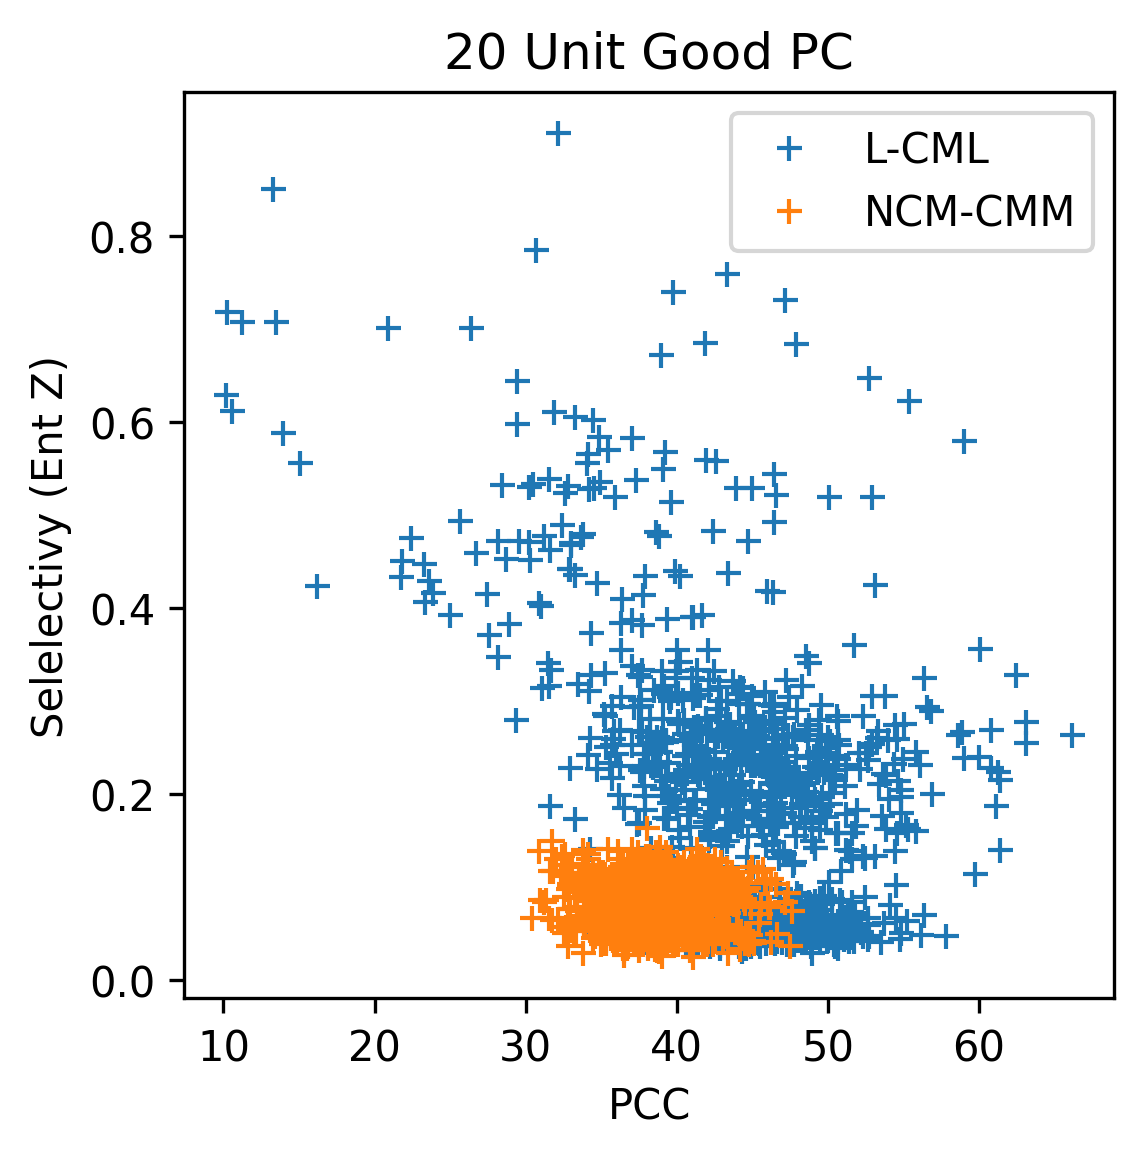

In [55]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for izone, zone in enumerate(Zones):
    ax.plot(pccZones[izone], selHZones[izone], '+', label = zone)

ax.set_xlabel('PCC')
ax.set_ylabel('Selelectivy (Ent Z)')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/scatterPCCSelH%dUnitGoodPCPerZone.eps' % numUnits)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


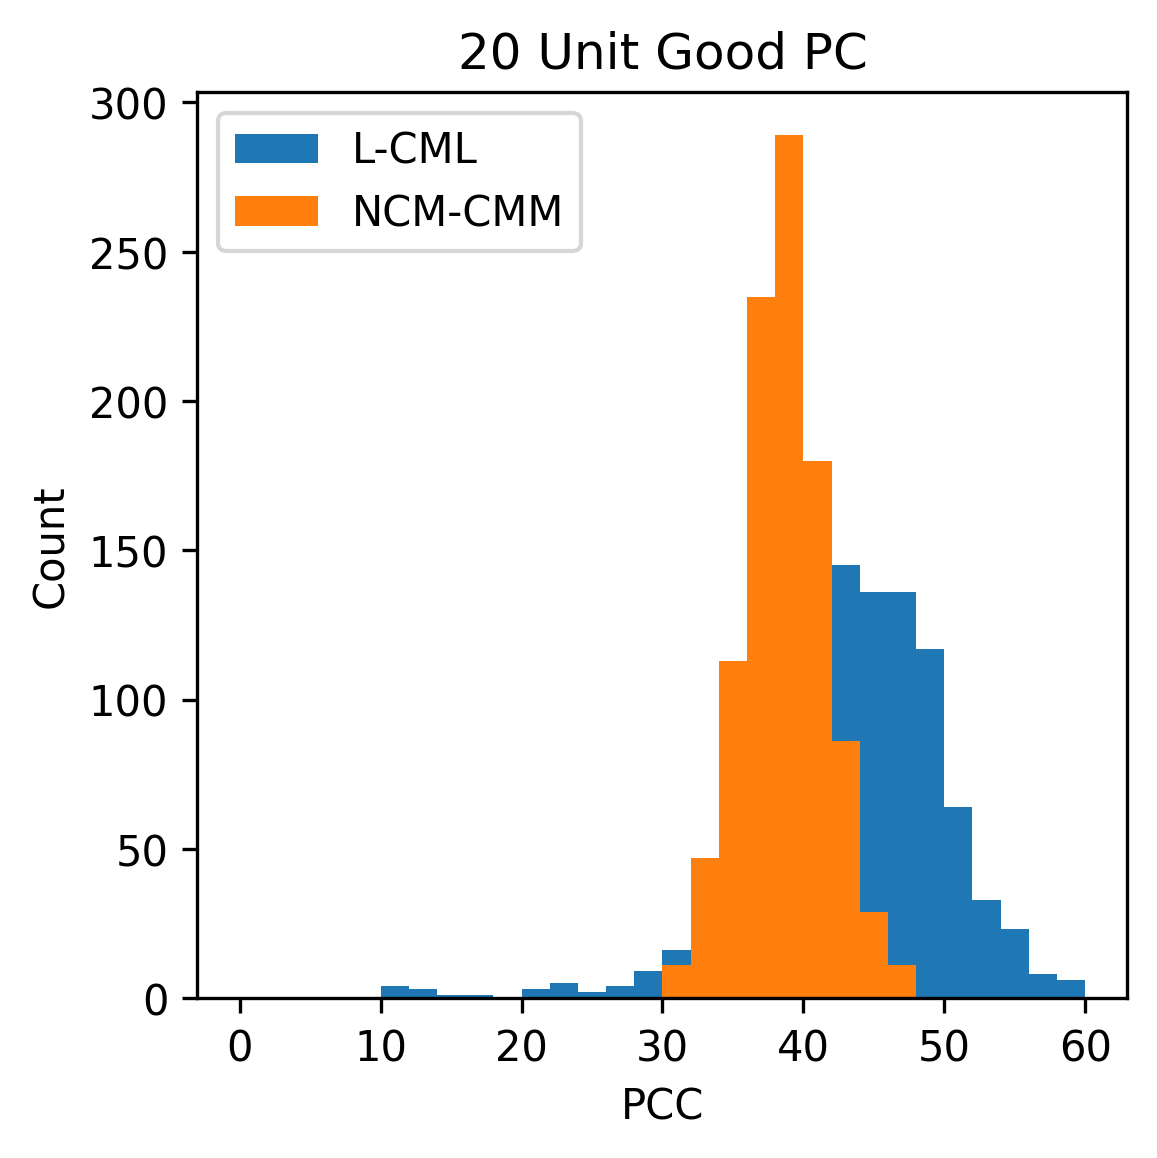

In [56]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for izone, zone in enumerate(Zones):
   ax.hist(pccZones[izone], bins = 30, range = (0,60), label=zone)

ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/pcchist%dUnitGoodPCPerZone.eps' % numUnits)

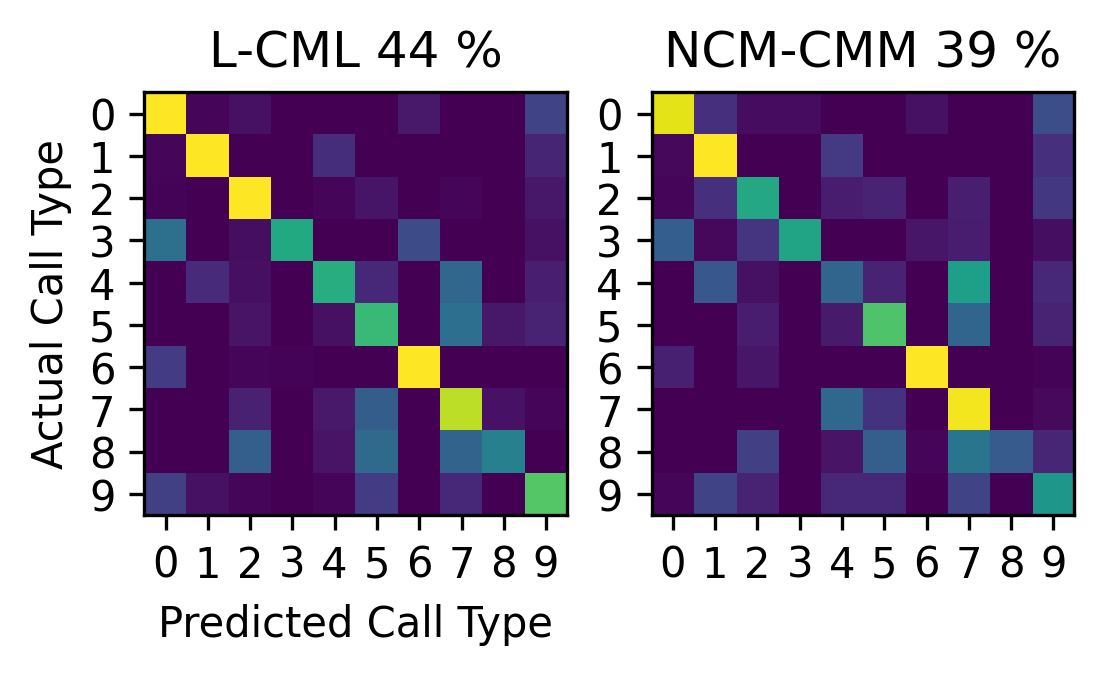

In [57]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,12), dpi=300)
axZones = fig.subplots(1, nZones)

for izone, zone in enumerate(Zones):
    ax = axZones[izone]
    im_ = ax.imshow(confMatTotZones[izone]*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 50)

    
    if izone == 0 :
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%s %.0f %%' % (zone, np.mean(pccZones[izone])))
    else:
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               # ylabel="Actual Call Type",
               # xlabel="Predicted Call Type",
               title='%s %.0f %%' % (zone, np.mean(pccZones[izone])))
        
plt.savefig('/Users/frederictheunissen/Desktop/confMat%dUnitGoodPCPerZone.eps' % numUnits)
